<a href="https://colab.research.google.com/github/keijikk/ml_study/blob/master/kaggle_submit_from_clab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# kaggleを使うための準備

In [1]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}


Download 100%.
- path is now set to: {/content}


In [4]:
!kaggle datasets list

ref                                                 title                                               size  lastUpdated          downloadCount  
--------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
kaggle/kaggle-survey-2018                           2018 Kaggle ML & DS Survey Challenge                 4MB  2018-11-03 22:35:07           1962  
lava18/google-play-store-apps                       Google Play Store Apps                               2MB  2018-09-18 20:49:49          17476  
census/family-households-with-married-couples-data  Family Households with Married Couples Data          2KB  2018-11-07 09:42:49           1114  
kmader/skin-cancer-mnist-ham10000                   Skin Cancer MNIST: HAM10000                          3GB  2018-09-20 20:36:13           2143  
xvivancos/transactions-from-a-bakery                Transactions from a bakery                         113KB  2018-09-

In [5]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


# 解析

タイタニックデータダウンロード

In [6]:
import os
os.getcwd()
os.chdir("/content/drive/My Drive/ML/kaggle/titanic")
!mkdir '/content/drive/My Drive/ML/kaggle/titanic'
!ls '/content/drive/My Drive/ML/kaggle/titanic'
!kaggle competitions download -c titanic -p '/content/drive/My Drive/ML/kaggle/titanic'


mkdir: cannot create directory ‘/content/drive/My Drive/ML/kaggle/titanic’: File exists
gender_submission.csv	 predict_result_rdf_data.csv  test.csv
predict_result_data.csv  predict_result_xgb_data.csv  train.csv
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
import pandas as pd 
import numpy as np
from sklearn.ensemble import RandomForestClassifier

In [24]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [25]:
d = train.Name.str.split(',', expand=True)
dd = d[1].str.split('.',expand=True)
train['Title'] = dd[0]

d = test.Name.str.split(',', expand=True)
dd = d[1].str.split('.',expand=True)
test['Title'] = dd[0]

train['Title'] = train['Title'].str.strip()
test['Title'] = test['Title'].str.strip()



train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [0]:
#print(train.Title.value_counts())
#print(test.Title.value_counts())

train['Title'] = train.Title.replace({'Dr': 'Others','Rev': 'Others', 'Major': 'Mr',
                     'Col': 'Others', 'Mlle': 'Others', 'Ms': 'Miss', 'the Countess': 'Others', 'Capt': 'Mr',
                     'Jonkheer': 'Others', 'Lady': 'Miss', 'Don': 'Mr', 'Sir': 'Mr', 'Mme': 'Others', 'Dona': 'Others'})

test['Title'] = test.Title.replace({'Dr': 'Others','Rev': 'Others', 'Major': 'Mr',
                     'Col': 'Others', 'Mlle': 'Others', 'Ms': 'Miss', 'the Countess': 'Others', 'Capt': 'Mr',
                     'Jonkheer': 'Others', 'Lady': 'Miss', 'Don': 'Mr', 'Sir': 'Mr', 'Mme': 'Others', 'Dona': 'Others'})


In [27]:
train['Embarked'] = train['Embarked'].fillna('S')# S is the most common symbol
test['Embarked'] = test['Embarked'].fillna('S')

train["Age"].fillna(train.Age.mean(), inplace=True) 
test["Age"].fillna(train.Age.mean(), inplace=True) 
test["Fare"].fillna(train.Fare.mean(), inplace=True)
train["FamilySize"] = train["SibSp"] + train["Parch"] + 1
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1

train.head()
#test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1


In [28]:
def get_dummied_df(df):
  df = df.drop(columns=["Name", "SibSp", "Parch", "Ticket", "Cabin" ])
  df["Pclass"] = df["Pclass"].astype(np.str)
  return pd.get_dummies(df, drop_first=True)


train_df = get_dummied_df(train)
test_df = get_dummied_df(test)

train_df.head()


,PassengerId,Survived,Age,Fare,FamilySize,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Others
0,1,0,22.0,7.2500,2,0,1,1,0,1,0,1,0,0
1,2,1,38.0,71.2833,2,0,0,0,0,0,0,0,1,0
2,3,1,26.0,7.9250,1,0,1,0,0,1,1,0,0,0
3,4,1,35.0,53.1000,2,0,0,0,0,1,0,0,1,0
4,5,0,35.0,8.0500,1,0,1,1,0,1,0,1,0,0


In [29]:
test_df.head()

,PassengerId,Age,Fare,FamilySize,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Others
0,892,34.5,7.8292,1,0,1,1,1,0,0,1,0,0
1,893,47.0,7.0000,2,0,1,0,0,1,0,0,1,0
2,894,62.0,9.6875,1,1,0,1,1,0,0,1,0,0
3,895,27.0,8.6625,1,0,1,1,0,1,0,1,0,0
4,896,22.0,12.2875,3,0,1,0,0,1,0,0,1,0


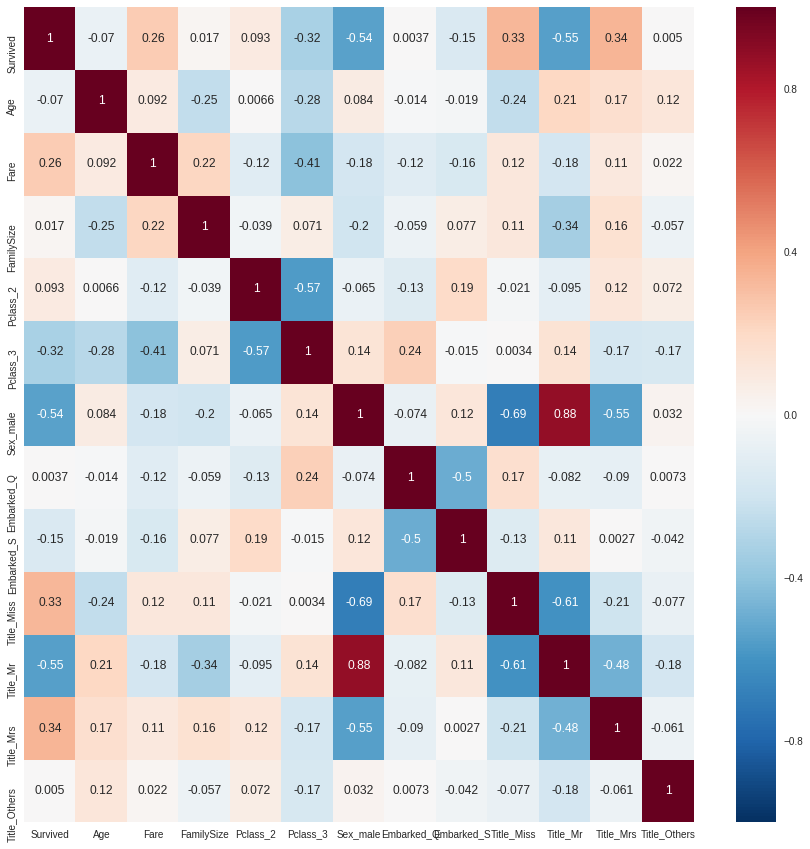

In [30]:
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
seaborn.heatmap(train_df.drop(columns=['PassengerId']).corr(), annot=True)

Ageの相関が低いので削除する

In [0]:
train_df = train_df.drop(columns=['Age'])
test_df = test_df.drop(columns=['Age'])

トレーニングデータで試してみる

In [0]:
x_df = train_df.drop(columns=['PassengerId','Survived'])
x_train = x_df.as_matrix()  
x_test = test_df.drop(columns=['PassengerId']).as_matrix()  
y_train = train_df['Survived'].as_matrix()


RFECVをお試しでやってみる。

In [41]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(3)

random_forest=RandomForestClassifier()
rfecv = RFECV(random_forest, cv=cv, scoring='accuracy', step=1)
rfecv.fit(x_train, y_train)
print(x_df.columns)
print('Feature ranking: \n{}'.format(rfecv.ranking_))
print('Rank 1 features: \n{}'.format(x_df.columns[rfecv.ranking_ == 1]))


Index(['Fare', 'FamilySize', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Others'],
      dtype='object')
Feature ranking: 
[1 1 4 1 1 5 3 2 1 6 7]
Rank 1 features: 
Index(['Fare', 'FamilySize', 'Pclass_3', 'Sex_male', 'Title_Mr'], dtype='object')


In [34]:
from sklearn.model_selection import train_test_split
(XX_train, XX_test,
 yy_train, yy_test) = train_test_split(
    x_train, y_train, test_size=0.3, random_state=0,
)

random_forest=RandomForestClassifier()
random_forest.fit(XX_train, yy_train)

print('Train score: {:.3f}'.format(random_forest.score(XX_train, yy_train)))
print('Test score: {:.3f}'.format(random_forest.score(XX_test, yy_test)))



Train score: 0.918
Test score: 0.813


In [35]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(XX_train, yy_train)
print('Train score: {:.3f}'.format(xgb.score(XX_train, yy_train)))
print('Test score: {:.3f}'.format(xgb.score(XX_test, yy_test)))


Train score: 0.862
Test score: 0.821


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


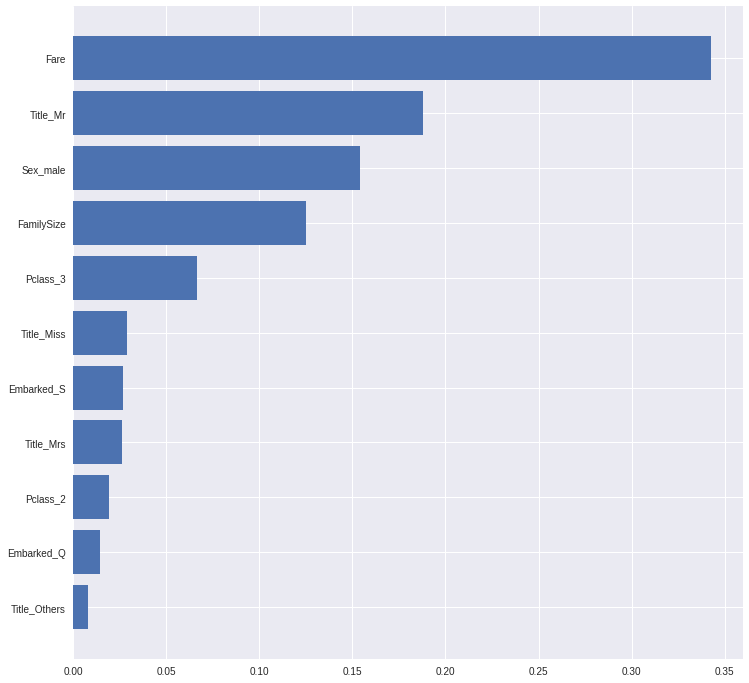

In [36]:
values, names = zip(*sorted(zip(random_forest.feature_importances_, x_df.columns)))

plt.figure(figsize=(12,12))
plt.barh(range(len(names)), values, align='center')
plt.yticks(range(len(names)), names)
plt.show()

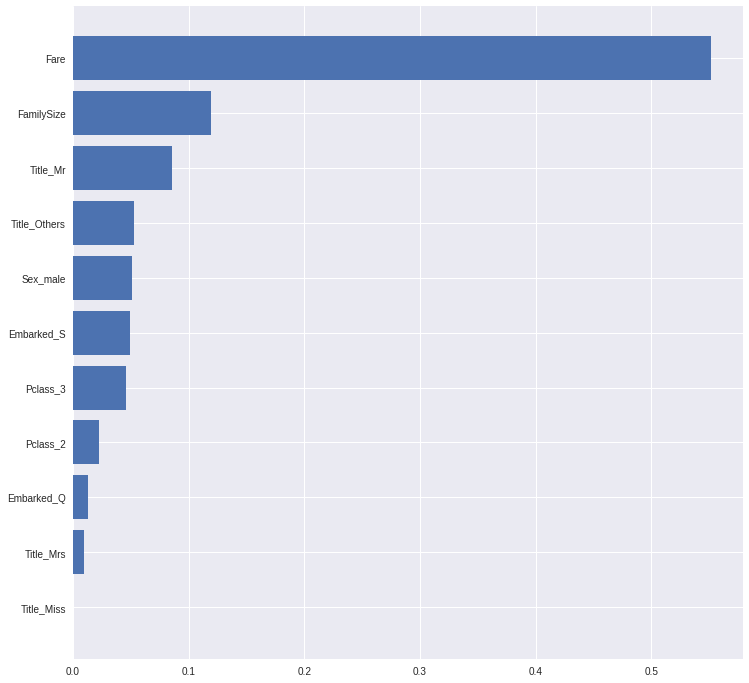

In [37]:
values, names = zip(*sorted(zip(xgb.feature_importances_, x_df.columns)))

plt.figure(figsize=(12,12))
plt.barh(range(len(names)), values, align='center')
plt.yticks(range(len(names)), names)
plt.show()

全データで学習

In [0]:
from sklearn.ensemble import RandomForestClassifier

random_forest=RandomForestClassifier()
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)

test_df["Survived"] = Y_pred.astype(np.int)
test_df[["PassengerId", "Survived"]].to_csv("predict_result_rdf_data.csv", index=False)


In [39]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
Y_pred = xgb.predict(x_test)

test_df["Survived"] = Y_pred.astype(np.int)
test_df[["PassengerId", "Survived"]].to_csv("predict_result_xgb_data.csv", index=False)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 提出

In [40]:
!ls
!kaggle competitions submit -c titanic -f predict_result_rdf_data.csv -m "rdf submit"
!kaggle competitions submit -c titanic -f predict_result_xgb_data.csv -m "sgb submit"

gender_submission.csv	 predict_result_rdf_data.csv  test.csv
predict_result_data.csv  predict_result_xgb_data.csv  train.csv
100% 2.77k/2.77k [00:01<00:00, 1.53kB/s]
Successfully submitted to Titanic: Machine Learning from Disaster